# Part IV: Roof Detection

### I. Necessary packages installation

In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os

### II. Main process of roof detection

All PyTorch model weights were used when initializing TFSamModel.

All the weights of TFSamModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


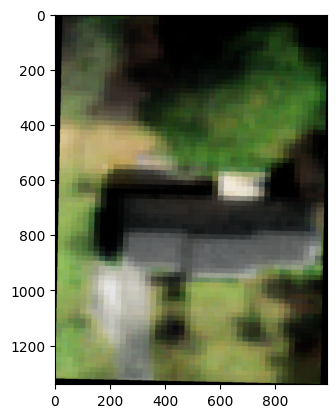

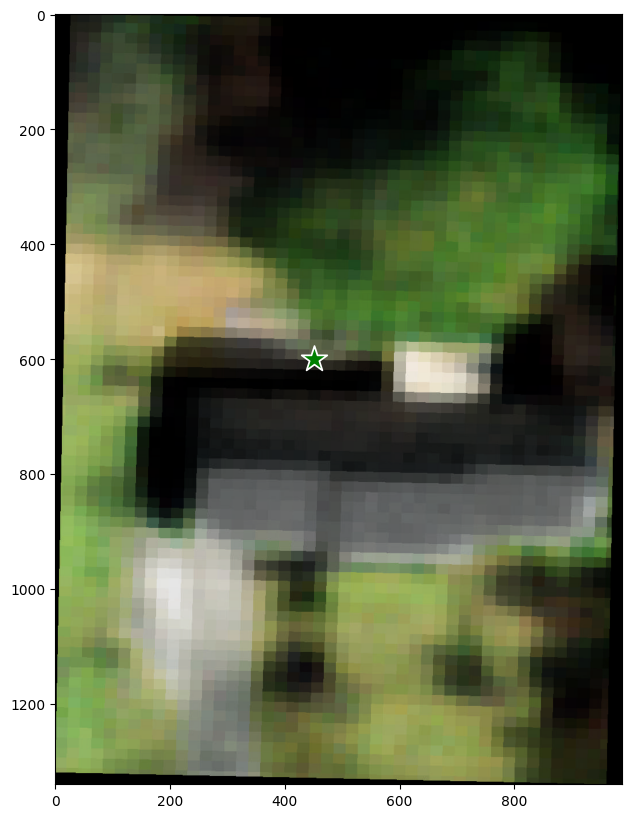

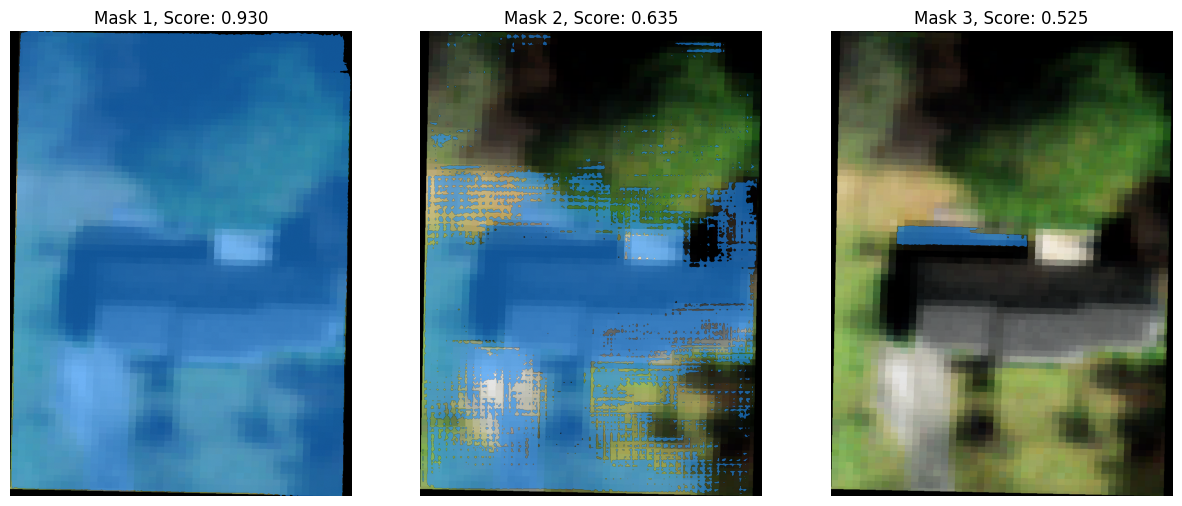

In [12]:
model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

np_config.enable_numpy_behavior()


def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_boxes_on_image(image, boxes):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_on_image(image, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points_and_boxes_on_image(image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    input_points = np.array(input_points)
    if input_labels is None:
        labels = np.ones_like(input_points[:, 0])
    else:
        labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
        show_box(box, plt.gca())
    plt.axis("on")
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_masks_on_image(image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

img_path = '/Users/yangchenxiang/Desktop/export_to_drive_000.jpg'  # Update this path
image = Image.open(img_path).convert('RGB')
plt.imshow(image)
plt.show()

input_points = [[[450, 600]]]

# Visualize a single point.
show_points_on_image(image, input_points[0])

# Preprocess the input image.
inputs = processor(image, input_points=input_points, return_tensors="tf")

# Predict for segmentation with the prompt.
outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks,
    inputs["original_sizes"],
    inputs["reshaped_input_sizes"],
    return_tensors="tf",
)

show_masks_on_image(image, masks, outputs.iou_scores)


### III. Roof Condition Classification